In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [33]:
# === Step 1: Load Data ===
ratings = pd.read_csv('combined_ratings.csv')
print("Original shape:", ratings.shape)

Original shape: (1000209, 14)


In [34]:
# === Step 2: Filter & Clean ===
# Filter out users/movies with few ratings
min_user_ratings = 44
min_movie_ratings = 50

user_counts = ratings['UserID'].value_counts()
movie_counts = ratings['MovieID'].value_counts()

ratings = ratings[ratings['UserID'].isin(user_counts[user_counts >= min_user_ratings].index)]
ratings = ratings[ratings['MovieID'].isin(movie_counts[movie_counts >= min_movie_ratings].index)]
print("Filtered shape:", ratings.shape)

Filtered shape: (934040, 14)


In [43]:
# === Step 3: Feature Engineering ===
# Normalize ratings per user (mean centering)
ratings['Rating_normalized'] = ratings.groupby('UserID')['Rating'].transform(lambda x: x - x.mean())

# Optional: create user demographic features (can be used later for fairness or hybrid filtering)
user_features = ratings[['UserID', 'Gender', 'Age', 'Occupation']].drop_duplicates().set_index('UserID')

In [40]:
# === Step 4: Create User-Item Matrix ===
user_item_matrix = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating_normalized')
print("User-item matrix shape:", user_item_matrix.shape)

User-item matrix shape: (4558, 2514)


In [41]:
# === Step 5: Train/Test Split (Custom per user) ===
train_matrix = user_item_matrix.copy() * np.nan
test_matrix = user_item_matrix.copy() * np.nan

for user_id in user_item_matrix.index:
    user_ratings = user_item_matrix.loc[user_id].dropna()
    if len(user_ratings) < 5:
        continue
    shuffled = user_ratings.sample(frac=1, random_state=42)
    cutoff = int(0.8 * len(shuffled))
    train_matrix.loc[user_id, shuffled.index[:cutoff]] = shuffled.values[:cutoff]
    test_matrix.loc[user_id, shuffled.index[cutoff:]] = shuffled.values[cutoff:]

In [15]:
test_long = test_matrix.stack().reset_index()
test_long.columns = ['UserID', 'MovieID', 'Rating']
test_long

,UserID,MovieID,Rating
0,1,594,-0.188679
1,1,661,-1.188679
2,1,914,-1.188679
3,1,1028,0.811321
4,1,1035,0.811321
...,...,...,...
188621,6040,3504,0.422961
188622,6040,3543,0.422961
188623,6040,3671,0.422961
188624,6040,3751,0.422961


In [16]:
# === Step 6: Fit UserKNN Model ===
# Fill NaNs in train matrix with 0 for cosine similarity
train_filled = train_matrix.fillna(0)

# Compute cosine similarity between users
similarity_matrix = cosine_similarity(train_filled)
similarity_df = pd.DataFrame(similarity_matrix, index=train_filled.index, columns=train_filled.index)

In [20]:
# === Step 7b: Hyperparameter Tuning — Grid Search for k ===
k_values = list(range(5, 51, 5))
results = []

print("\nTuning k...")
for k in k_values:
    predictions = []
    actuals = []

    for row in test_long.itertuples(index=False):
        uid, iid, true_rating = row
        pred = predict_rating(uid, iid, k=k)
        if not np.isnan(pred):
            predictions.append(pred)
            actuals.append(true_rating)

    rmse = mean_squared_error(actuals, predictions, squared=False)
    results.append((k, rmse))
    print(f"k={k} → RMSE: {rmse:.4f}")

# Show best k
best_k, best_rmse = min(results, key=lambda x: x[1])
print(f"\nBest k: {best_k} with RMSE: {best_rmse:.4f}")


Tuning k...
k=5 → RMSE: 0.9328
k=10 → RMSE: 0.8999
k=15 → RMSE: 1.3862
k=20 → RMSE: 0.8849
k=25 → RMSE: 0.8825
k=30 → RMSE: 0.8814
k=35 → RMSE: 0.8846
k=40 → RMSE: 0.8820
k=45 → RMSE: 0.8888
k=50 → RMSE: 0.9645

✅ Best k: 30 with RMSE: 0.8814


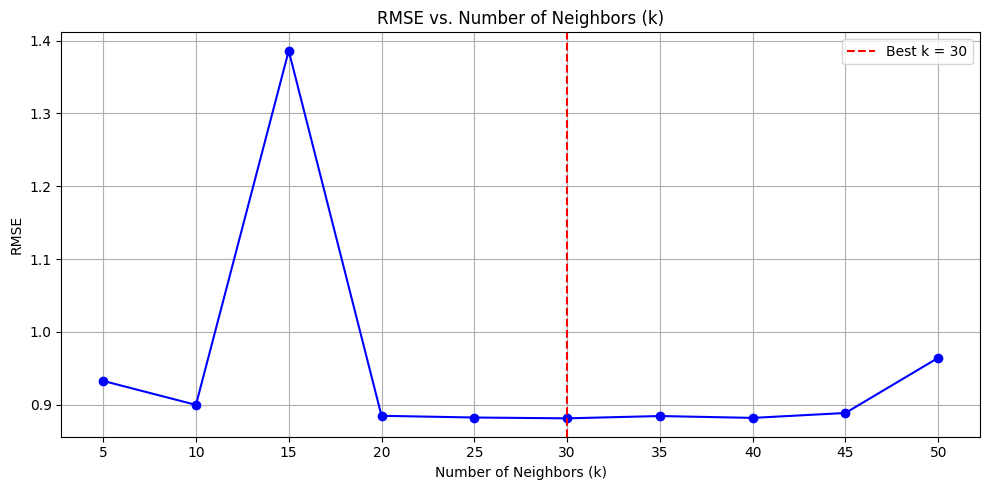

In [24]:
# Zet resultaten om in een DataFrame voor nettere plotting
results_df = pd.DataFrame(results, columns=['k', 'RMSE'])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(results_df['k'], results_df['RMSE'], marker='o', linestyle='-', color='blue')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.title('RMSE vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.xticks(results_df['k'])  # Zorg dat alle k-waarden als ticks staan
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# === Step 8 (revisited): Predict on Test Set with Best k ===
print(f"\nRe-running final predictions using k={best_k}")
predictions = []
actuals = []

for row in tqdm(test_long.itertuples(index=False)):
    uid, iid, true_rating = row
    pred = predict_rating(uid, iid, k=best_k)
    if not np.isnan(pred):
        predictions.append(pred)
        actuals.append(true_rating)

rmse = mean_squared_error(actuals, predictions, squared=False)
print(f"\nFinal UserKNN RMSE after tuning: {rmse:.4f}")


Re-running final predictions using k=30


188626it [02:05, 1501.44it/s]


Final UserKNN RMSE after tuning: 0.8814


In [22]:
# === Step 9: Evaluate ===
rmse = mean_squared_error(actuals, predictions, squared=False)
print(f"\nFinal UserKNN RMSE: {rmse:.4f}")


Final UserKNN RMSE: 0.8814
